# 认知神经科学2025
## 大作业课题4示例代码
### 2025.11.10

Demo包含内容：
1. 读入fMRI响应和刺激文件
2. 利用预训练模型提取刺激特征
3. 拟合编码模型
4. 可视化

### Prerequisite
1. 阅读指南2.4（fMRI），4.2节（GLM），以及可视化demo代码
2. 对于深度学习和语言模型有基本的认识
3. Pytorch库和huggingface transformers库的基本知识
    
    Pytorch：https://pytorch.org
    https://github.com/yunjey/pytorch-tutorial

    transformers：https://huggingface.co/docs/transformers/index

4. 关于文本模型（如GPT2）和音频模型（Wav2vec等）的加载和调用有基本了解
    
    GPT2：https://huggingface.co/docs/transformers/en/model_doc/gpt2
    
    Wav2vec：https://huggingface.co/docs/transformers/model_doc/wav2vec2

### 同样使用Narratives数据集的工作：
1. Binhuraib T, Gao R, Ivanova A A. LITcoder: A General-Purpose Library for Building and Comparing Encoding Models[J]. arXiv preprint arXiv:2509.09152, 2025.
2. Millet J, Caucheteux C, Boubenec Y, et al. Toward a realistic model of speech processing in the brain with self-supervised learning[J]. Advances in Neural Information Processing Systems, 2022, 35: 33428-33443.
3. Oota S R, Gupta M, Toneva M. Joint processing of linguistic properties in brains and language models[J]. Advances in Neural Information Processing Systems, 2023, 36: 18001-18014.
4. Kumar S, Sumers T R, Yamakoshi T, et al. Shared functional specialization in transformer-based language models and the human brain[J]. Nature communications, 2024, 15(1): 5523.


## 1. 读入fMRI响应

### 1.1 安装和加载必要的库

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%pip install transformers librosa -qq

In [1]:
from pathlib import Path
import numpy as np
import librosa
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

from src.utils import get_tokenizer_valid_len, extract_text_features

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 1.2 加载被试听21st year故事的fMRI响应
21styear_all_subs_rois.npy保存了一个dict，包含25名被试

In [2]:
# 加载所有被试听21styear故事时的fMRI响应
fmris = np.load('data/raw/21styear_all_subs_rois.npy', allow_pickle=True).item()
n_trs = fmris[75].shape[0]  # TR数量

print(len(fmris))
print(fmris.keys())
print(fmris[75].shape)  # (TRs, ROIs)

25
dict_keys([75, 131, 190, 201, 235, 244, 249, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271])
(2249, 360)


## 2. 加载刺激文件 & 提取刺激特征

### 2.1 加载文本

csv文件包含故事文本，每个单词的起始和结束时刻。需要把单词对齐到TR（1.5 s），这里采用的方式是如果**单词的起始时刻**在某一TR内，就把该单词划至该TR。

In [3]:
# 读入csv文件, cased/uncased为文本, start_ts/end_ts为单词起始和结束时刻
df = pd.read_csv('data/raw/21styear_align.csv', header=None, names=["cased", "uncased", "start_ts", "end_ts"])

df.cased = df.cased.fillna("none")
df.end_ts = df.end_ts.bfill()
df.start_ts = df.start_ts.bfill()

# time (s) -> TR (1.5s)
df['tr'] = df.start_ts.apply(lambda x: np.ceil(x / 1.5).astype(int))
print(df.shape) # (num_words, 5)

df.head()

(8267, 5)


,cased,uncased,start_ts,end_ts,tr
0,This,this,21.219999,21.289999,15
1,is,is,21.460000,21.650000,15
2,Los,los,21.660000,21.940000,15
3,Angeles,angeles,21.940000,22.770000,15
4,And,and,22.810000,22.960000,16


### 2.2 加载模型
加载transformers库提供的预训练模型，此处以文本模型GPT2为例，建议加载到GPU上。

In [4]:
# 对于大模型，可以选择半精度加载以节省显存
load_in_half = False
model_dir = './'

# 注意这里的add_prefix_space参数, 对于GPT-2等以空格为词边界的tokenizer非常重要
tokenizer = AutoTokenizer.from_pretrained('gpt2', cache_dir=model_dir, add_prefix_space=True)
text_model = AutoModel.from_pretrained('gpt2', cache_dir=model_dir,
                                #   dtype=torch.bfloat16 if load_in_half else torch.float32
                                  ).eval().to(device)

text_model

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [5]:
# 测试tokenizer对于空格的处理
print(tokenizer.convert_ids_to_tokens(tokenizer.encode('hi I am')))
print(tokenizer.convert_ids_to_tokens(tokenizer.encode('hi', add_special_tokens=False) +\
                                      tokenizer.encode('I', add_special_tokens=False) +\
                                      tokenizer.encode('am', add_special_tokens=False)))

['Ġhi', 'ĠI', 'Ġam']
['Ġhi', 'ĠI', 'Ġam']


### 2.3 处理文本

对每一个TR，提取指定窗口大小的单词上下文，这里设置上下文窗口为200 tokens。

In [6]:
# 获取tokenizer的有效长度和特殊token id
valid_len, (cls_ids, eos_ids) = get_tokenizer_valid_len(tokenizer)
valid_len, cls_ids, eos_ids

(1023, [], [50256])

In [7]:
# 设置提取文本特征的上下文窗口，不能超过tokenizer的有效长度
ctx_words = 200
if ctx_words > valid_len:
    raise ValueError(f"Window size {ctx_words} exceeds tokenizer valid length {valid_len}.")

利用tokenizer进行分词，分词后再提取单词上下文（如果按照词级别提取窗口再分词，最后的序列长度会远大于指定的ctx_words）

In [8]:
token_ids = []
token_with_ctx = []

for idx in range(len(df)):
    token_id = tokenizer.tokenize(df.loc[idx, 'cased'], add_special_tokens=False)
    token_ids.extend(token_id)
    ctx_start_idx = max(len(token_ids) - ctx_words, 0)
    tr_context = token_ids[ctx_start_idx:]
    token_with_ctx.append(tr_context)

print(token_with_ctx[2:5])
len(token_with_ctx), max(map(len, token_with_ctx))

[['ĠThis', 'Ġis', 'ĠLos'], ['ĠThis', 'Ġis', 'ĠLos', 'ĠAngeles'], ['ĠThis', 'Ġis', 'ĠLos', 'ĠAngeles', 'ĠAnd']]


(8267, 200)

### 2.4 提取文本特征

利用预训练模型提取**每个单词**对应的文本特征并保存，建议用**py脚本运行下列代码**，jupyter notebook加载模型和跑GPU任务有时候容易崩溃。

In [ ]:
# 建议用py脚本运行 (jupyter notebook加载模型和跑GPU任务有时候容易崩溃)
feature_save_path = Path('.')
# 注意对于huggingface的语言模型, layer索引从0开始计数 (第0层为embedding层)
layers = [6]

layer_features = extract_text_features(tokens=token_with_ctx,
                                       tokenizer=tokenizer,
                                       model=text_model,
                                       layers=layers,
                                       device=device,
                                       batch_size=64,
                                       autocast=load_in_half,
                                       pooling='last')

# 保存每一层的特征
for layer, features in layer_features.items():
    layer_file_name = f'gpt2_21styear_win{ctx_words}_layer{layer}_features.npy'
    layer_file = feature_save_path / layer_file_name
    np.save(layer_file, features, allow_pickle=True)

    print(f'Saving gpt2 (layer {layer}) features at {layer_file.as_posix()}: '\
            f'shape {features.shape}, mean = {features.mean():.3f}, std = {features.std():.3f}')

In [10]:
# 加载提取的特征
feature_save_path = Path('.')
layer = 6
layer_feature = np.load(feature_save_path / f'gpt2_21styear_win{ctx_words}_layer{layer}_features.npy')
layer_feature.shape

(8267, 768)

整合**同一个TR内**所有的单词特征，此处采用mean pooling, 即对TR内出现的所有单词特征取平均。

In [11]:
# 整合同一个TR内所有的单词特征
# 此处采用mean pooling, 即对TR内出现的所有单词特征取平均
# Todo: 尝试不同的pooling方式
first_tr, last_tr = df.tr.min(), df.tr.max()
print(first_tr, last_tr)

aligned_tr_feats = []
for tr in range(first_tr, last_tr + 1):
    if tr in df.tr.values:
        tr_indices = df.index[df.tr == tr].tolist()
        tr_features = layer_feature[tr_indices].mean(0)
    # 若该TR无单词，则用前一TR的特征代替
    aligned_tr_feats.append(tr_features)

aligned_tr_feats = np.vstack(aligned_tr_feats)

# 用0向量填充最开始的空TR
aligned_tr_feats = np.pad(aligned_tr_feats, ((first_tr - 1, 0), (0, 0)), mode='constant')
# 用最后一个TR的特征填充末尾的空TR
aligned_tr_feats = np.pad(aligned_tr_feats, ((0, n_trs - last_tr), (0, 0)), mode='edge')
aligned_tr_feats.shape

15 2240


(2249, 768)

In [12]:
# pandas等价实现
first_tr, last_tr = int(df.tr.min()), int(df.tr.max())
print(f"TR range: {first_tr} → {last_tr}")

# 调用groupby函数
tr_means = df.groupby("tr").apply(lambda g: layer_feature[g.index].mean(0))
tr_means = tr_means.reindex(range(first_tr, n_trs + 1))
tr_means = tr_means.ffill()  # 填充缺失TR，用前一TR替代

tr_means = np.vstack(tr_means.to_numpy())

# 用0向量填充最开始的空TR
aligned_tr_feats1 = np.pad(tr_means, ((first_tr - 1, 0), (0, 0)), mode='constant')
print("Aligned features:", aligned_tr_feats1.shape)

np.allclose(aligned_tr_feats, aligned_tr_feats1)

TR range: 15 → 2240
Aligned features: (2249, 768)


C:\Users\dell\AppData\Local\Temp\ipykernel_58932\2559764522.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tr_means = df.groupby("tr").apply(lambda g: layer_feature[g.index].mean(0))


True

### 2.5 处理音频

利用**librosa**库加载音频文件（把整段音频读入内存，音频较长时可进行分段裁剪，也可以利用torchaudio库的io.StreamReader进行流式读取）

In [13]:
wav, sr = librosa.load('data/raw/21styear_audio.wav', sr=16000)
wav = torch.from_numpy(wav)
wav.shape, wav.shape[0] / sr  # 音频时长 (秒)

(torch.Size([53987982]), 3374.248875)

为每一个TR裁剪相应的音频片段。

**Todo：尝试不同的窗口时长**（此处设置窗长为 $2 TR = 3s$）

In [14]:
# 切分每个TR对应的音频
# Todo: 尝试不同的窗口大小

tr_frames = int(sr * 1.5)
tr_wav_win = 2 # 提取音频特征时的窗口大小 (单位: TR)

# 切分音频为多个chunk, 每个chunk包含batch_size个TR的音频数据
# unfold操作类似于滑动窗口切分
# ref: https://docs.pytorch.org/docs/stable/generated/torch.Tensor.unfold.html
audio_chunks = wav.flip(0).unfold(0, tr_frames * tr_wav_win, tr_frames).flip([0, 1])

# 前几个TR对应的有效音频时长小于窗长, 用第一个chunk填充
num_chunks = audio_chunks.shape[0]
pad_count = n_trs - num_chunks
if pad_count > 0:
    pad_chunk = audio_chunks[0].unsqueeze(0).repeat(pad_count, 1)  # shape: (pad_count, chunk_len)
    audio_chunks = torch.cat([pad_chunk, audio_chunks], dim=0)

audio_chunks.shape

torch.Size([2249, 48000])

### 2.6 提取音频特征（此处省略）

**Todo：参考文本特征的提取方式，自行编写代码提取音频特征**

## 3. 拟合体素编码模型

### 3.1 PCA降维（可选）
特征提取完成后，可对特征进行PCA降维，以减少后续拟合模型的时间。

In [15]:
# PCA降维特征 (可选)
# 严谨的做法是先在训练集上fit PCA, 再应用到验证集/测试集
# 这里为了实现简便, 直接在整个数据集上fit_transform

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
aligned_feats_std = scaler.fit_transform(aligned_tr_feats)
pca = PCA(n_components=250)
aligned_tr_feats = pca.fit_transform(aligned_feats_std)
aligned_tr_feats.shape

(2249, 250)

### 3.2 建模血氧动力学延迟

指南2.4节提到，BOLD响应可视为**线性时不变（LTI）系统**，其单位脉冲响应被称为**血动力学响应函数（HRF）**。具体而言，单一刺激的fMRI响应具有滞后性，大约在刺激后的5s左右才能达到峰值。为建模血氧动力学延迟，可以选择用刺激函数卷积标准HRF，或是根据数据“学习”一个HRF（即有限脉冲响应FIR）。

这里采用FIR方法（Gallant/Huth组的工作最喜欢用的方式），也就是把过去若干TR的刺激拼接起来：

设计矩阵$X_{origin}\in\mathbb{R}^{n_{TR}\times d} \rightarrow X_{FIR}\in\mathbb{R}^{n_{TR}\times (k\cdot d)}$，$k$为FIR的时间窗，$d$为特征维度），统一拟合当前TR的响应，即

$y_{t} = f(X_{t-1}, X_{t-2}, ..., X_{t-k})$

LTI系统：

https://www.princeton.edu/~cuff/ele301/files/lecture3_2.pdf

https://sceweb.sce.uhcl.edu/harman/CENG3315_DSP_Spring2020/00_3315_2021/3315_web_2021/3315_Lectures_Sp2021/Lecture_3_22_2010/CENG3315_Review6_Ch5_FIR_Convolve_LTI.pdf


In [16]:
# 构造FIR特征, 此处window=4表示使用前4个TR的特征, (拼接TR_{t-1}, TR_{t-2}, TR_{t-3}, TR_{t-4})
# 预测当前TR的fMRI响应

from src.utils import concat_feature
 
fir_features = concat_feature(aligned_tr_feats, window=4, offset=1)
fir_features = fir_features.reshape(fir_features.shape[0], -1)
fir_features.shape

(2249, 1000)

In [17]:
# 使用for循环实现的等价版本 (前人工作中多参考该实现)
from src.utils import concat_feature_with_for_loop
fir_features_loop = concat_feature_with_for_loop(aligned_tr_feats, delays=np.arange(1, 5))
np.allclose(fir_features, fir_features_loop)

True

### 3.3 划分数据集，拟合岭回归模型

由于数据集较小（$2249 TRs$），这里参考之前的工作，不额外划分验证集，而是采用**5-fold交叉验证，通过测试集的平均Pearson corr**评估模型的预测性能，超参数通过**嵌套交叉验证**（nested CV）选取。

**Todo：做多被试分析，报告均值和标准差**

In [18]:
# 对每个被试进行编码模型拟合和交叉验证, 此处以被试75为例
# 由于样本数有限, 不单独划分测试集, 根据5-fold交叉验证的测试集平均corr评估模型性能
# Todo: 做多被试分析

from src.utils import fit_encoding_cv
from sklearn.model_selection import KFold

kfold = 5
outer_cv = KFold(n_splits=kfold, shuffle=False)
alphas = [10000., 100000., 1000000.]
sub = 75

# 排除开头和结尾的TR以避免边界效应
excluded_start, excluded_end = 10, 10

model, corr_map = fit_encoding_cv(X=fir_features,
                                  y=fmris[sub],
                                  cv_splitter=outer_cv,
                                  alphas=alphas,
                                  excluded_start=excluded_start,
                                  excluded_end=excluded_end)

best_alpha = model.alpha_ if hasattr(model, 'alpha_') else model.alpha
print(f'Subject {sub} model fitted. Best alpha: {best_alpha}, mean CV corr: {np.mean(corr_map):.3f}')

Subject 75 model fitted. Best alpha: 1000000.0, mean CV corr: 0.013


### 3.4 可视化相关系数的皮层分布

利用MMP atlas的surface文件，可视化之前得到的correlation map（左右半球各包含41k vertices）。

**Todo：分析不同模型、不同层特征预测性能的皮层分布模式；尝试分析不同ROI的预测性能差异**

In [19]:
from brainspace.plotting.surface_plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from neuromaps.datasets import fetch_atlas
from src.utils import extract_hemi_data_from_files

fslr = fetch_atlas('fsaverage', '41k', data_dir='.')
# 读入表面模板文件，用于后续可视化
# inflated表示膨胀后的表面网格，fslr['inflated']是一个字典，包含左右两个表面文件的路径
# （pathlib.WindowsPath对象，需要转换成str）
surf_lh = read_surface(str(fslr['inflated'].L))
surf_rh = read_surface(str(fslr['inflated'].R))

In [21]:
path = Path('.')
tpl_files = list(path.glob('*MMP*gii'))
whole_brain_rois = extract_hemi_data_from_files(tpl_files, is_label=True, return_list=False).astype(int)

whole_brain_rois.shape

(81924,)

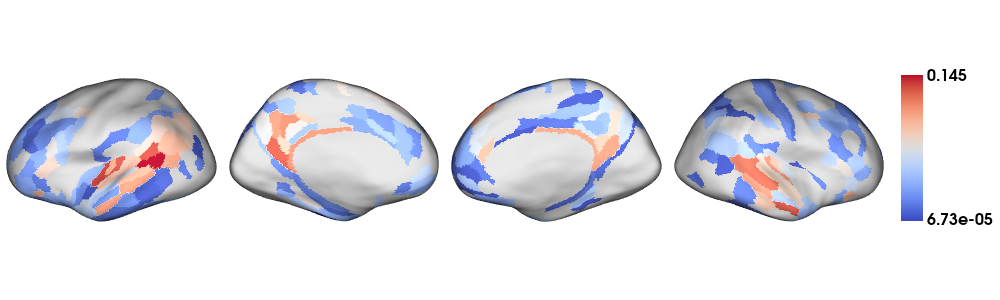

In [22]:
whole_brain_corrs = np.zeros(whole_brain_rois.shape, dtype=np.float32)

for roi_ind in np.unique(whole_brain_rois[whole_brain_rois != 0]):
    whole_brain_corrs[whole_brain_rois == roi_ind] = corr_map[roi_ind - 1]

# medial wall设为nan, 后续可视化为灰色
whole_brain_corrs[whole_brain_rois == 0] = np.nan
# 设置相关阈值为0 (保留正相关), 后续可进一步调整阈值
whole_brain_corrs[whole_brain_corrs < 0.] = np.nan

plot_hemispheres(surf_lh, surf_rh,
                array_name=whole_brain_corrs,
                nan_color=(0.8, 0.8, 0.8, 1),
                background=(1, 1, 1),
                size=(1000, 300),
                embed_nb=True,
                color_bar=True,
                # color_range=(0, 0.5),
                interactive=False,
                transparent_bg=False,
                cmap='coolwarm',
                zoom=1.2,
                text__textproperty={'fontsize': 50},
                )